In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import PIL
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
#Change to correct path where you keep your images

import pathlib

DIRECTORY = r'C:\Users\emma_\Downloads\houseNY'
data_dir = pathlib.Path(DIRECTORY)

In [3]:
#Define parameters for the loader.
#This is the default parameters from the tutoriol. 

batch_size = 32
img_height = 180
img_width = 180

In [4]:
#Creating a validation split. Using 80% of the pictures for training.

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 542 files belonging to 2 classes.
Using 434 files for training.


In [5]:
# using 20% of the pictures for validation.

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 542 files belonging to 2 classes.
Using 108 files for validation.


In [6]:
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['basementNY', 'no_basementNY']


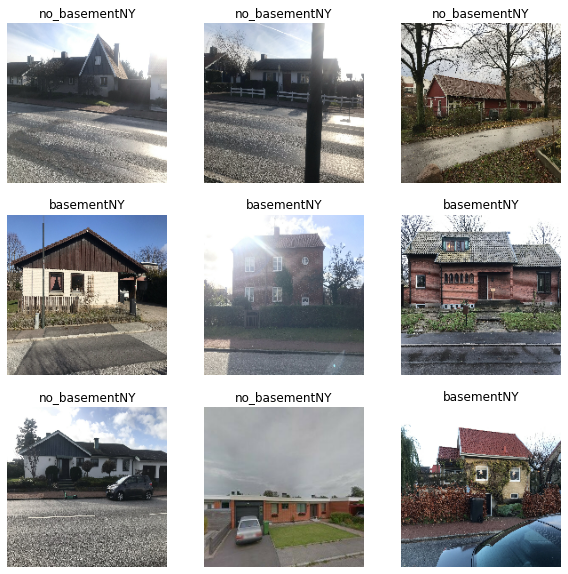

In [7]:
# Visualize the data
# Here are the first nine images from the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
# manually iterate over the dataset and retrieve batches of images

# The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 
# The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [9]:
# Configure the dataset for performance
# make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 
# These are two important methods you should use when loading data:

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 

# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
# Dataset.prefetch overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Standardize the data
# The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; 
# in general you should seek to make your input values small.

# Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

normalization_layer = layers.Rescaling(1./255)

In [11]:

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9867306


In [12]:
# Create the model
# The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer 
# (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) 
# with 128 units on top of it that is activated by a ReLU activation function ('relu'). 

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
# Compile the model
# Choosed the tf.keras.optimizers.Adam optimizer 
# and tf.keras.losses.SparseCategoricalCrossentropy loss function. 
# To view training and validation accuracy for each training epoch, 
# pass the metrics argument to Model.compile.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View all the layers of the network using the model's Model.summary method

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [16]:
#Train the model

epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
14/14 [==============================] - 5s 323ms/step - loss: 0.8836 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5926
Epoch 2/50
14/14 [==============================] - 4s 257ms/step - loss: 0.6903 - accuracy: 0.5714 - val_loss: 0.6888 - val_accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 3s 228ms/step - loss: 0.6718 - accuracy: 0.6475 - val_loss: 0.6851 - val_accuracy: 0.5185
Epoch 4/50
14/14 [==============================] - 3s 228ms/step - loss: 0.6203 - accuracy: 0.7028 - val_loss: 0.6550 - val_accuracy: 0.5833
Epoch 5/50
14/14 [==============================] - 3s 239ms/step - loss: 0.5380 - accuracy: 0.7535 - val_loss: 0.6265 - val_accuracy: 0.6296
Epoch 6/50
14/14 [==============================] - 3s 211ms/step - loss: 0.4500 - accuracy: 0.7926 - val_loss: 0.5783 - val_accuracy: 0.6759
Epoch 7/50
14/14 [==============================] - 3s 219ms/step - loss: 0.3488 - accuracy: 0.8548 - val_loss: 0.6672 - val_accuracy: 0.7130
Epoch 

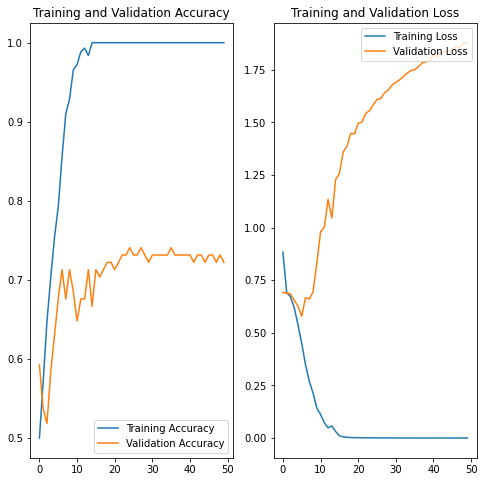

In [17]:
# Visualize training results
# Create plots of loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# The plots show that training accuracy and validation accuracy are off by large margins

This can be a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. Here we use data augmentation and Dropout.

In [14]:
# Data augmentation
# Overfitting generally occurs when there are a small number of training examples. 
# Data augmentation takes the approach of generating additional training data 
# from your existing examples by augmenting them using random transformations that yield believable-looking images. 
# This helps expose the model to more aspects of the data and generalize better.

# You will implement data augmentation using the following Keras preprocessing layers: 
# tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. 
# These can be included inside your model like other layers, and run on the GPU.


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

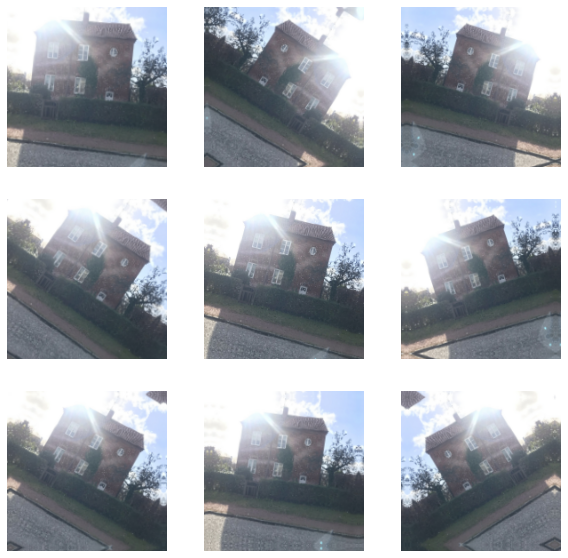

In [20]:
# Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
        

# Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units 
from the layer during the training process. Dropout takes a fractional number as its input value, 
in the form such as 0.1, 0.2, 0.4, etc. 
This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [21]:
# Creating a new neural network with tf.keras.layers.Dropout before training it using the augmented images

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
#Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [24]:
#Train the model

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
14/14 [==============================] - 5s 293ms/step - loss: 0.9260 - accuracy: 0.5253 - val_loss: 0.7001 - val_accuracy: 0.4815
Epoch 2/50
14/14 [==============================] - 5s 351ms/step - loss: 0.6949 - accuracy: 0.5046 - val_loss: 0.6936 - val_accuracy: 0.4722
Epoch 3/50
14/14 [==============================] - 3s 234ms/step - loss: 0.6940 - accuracy: 0.4839 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 4/50
14/14 [==============================] - 3s 233ms/step - loss: 0.6931 - accuracy: 0.5276 - val_loss: 0.6931 - val_accuracy: 0.5185
Epoch 5/50
14/14 [==============================] - 4s 249ms/step - loss: 0.6932 - accuracy: 0.4770 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 6/50
14/14 [==============================] - 4s 271ms/step - loss: 0.6930 - accuracy: 0.5138 - val_loss: 0.6936 - val_accuracy: 0.4630
Epoch 7/50
14/14 [==============================] - 4s 291ms/step - loss: 0.6924 - accuracy: 0.5276 - val_loss: 0.6924 - val_accuracy: 0.5278
Epoch 

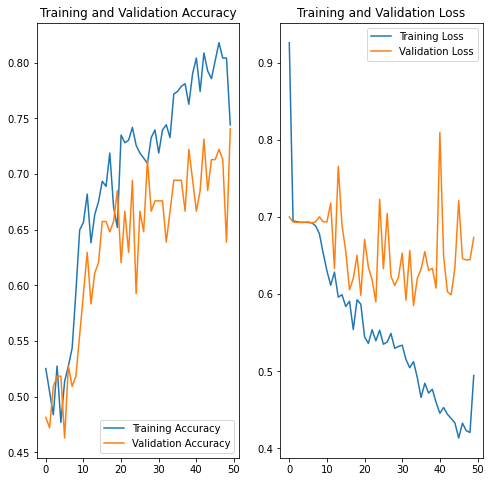

In [27]:
# Visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Code to manually test the model with new images.

In [28]:

img = tf.keras.utils.load_img(
    "ejK1.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to no_basementNY with a 99.85 percent confidence.
